<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "8J"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/8J/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


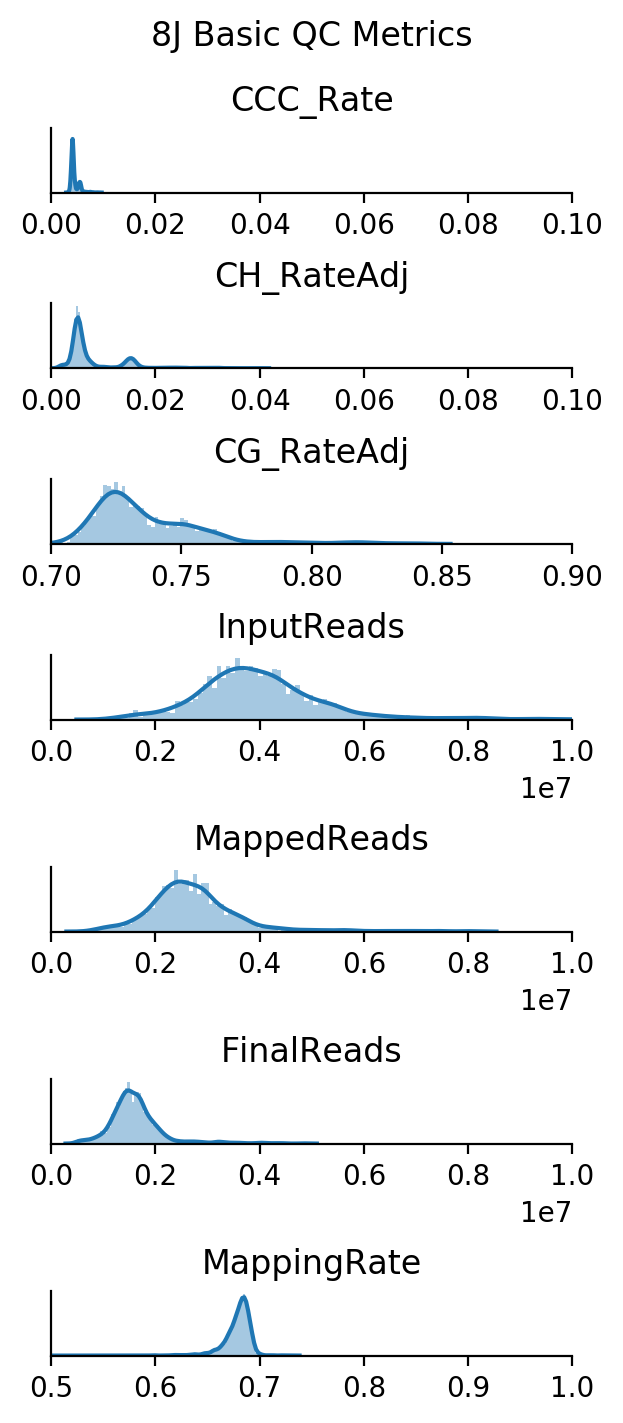

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

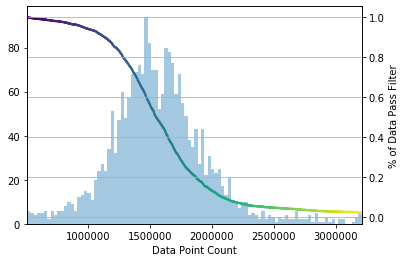

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2290/2290 (100.0%)
CG_RateAdj passed 2290/2290 (100.0%)
CH_RateAdj passed 2290/2290 (100.0%)
FinalReads passed 2290/2290 (100.0%)
MappingRate passed 2290/2290 (100.0%)
Overall passed 2290/2290 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190711 1337
190716 953


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 251 65.4%
ad002 270 70.3%
ad004 248 64.6%
ad006 243 63.3%
ad007 325 84.6%
ad008 327 85.2%
ad010 311 81.0%
ad012 315 82.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
8J_M_0,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-1...,0.003910,0.722346,0.721256,0.008786,0.004896,998343.0,2289198,1571980.0,8J,...,-17.430645,-6.777603,24.418652,9.428479,DG dg-all,-2.053192,-10.156404,26.757322,3.964568,True
8J_M_1,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-1...,0.004021,0.734058,0.732984,0.010141,0.006144,1425219.0,3326942,2286507.0,8J,...,-18.365780,-11.254463,-5.719425,0.060718,DG dg-all,-3.499860,-5.396046,-4.430060,26.353780,True
8J_M_10,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-1...,0.004044,0.728037,0.726933,0.009165,0.005143,1458851.0,3410736,2279114.0,8J,...,-19.555017,-9.567721,1.561517,-4.796768,DG dg-all,-3.946168,-6.095679,1.700636,24.069534,True
8J_M_100,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-1...,0.005112,0.767559,0.766364,0.018786,0.013744,1741208.0,4381782,2986649.0,8J,...,-15.089827,-5.829557,25.723790,39.616516,CA3 Cadm2,-2.864757,-11.196486,-26.370656,-16.247673,True
8J_M_1000,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-3...,0.004119,0.727366,0.726238,0.009615,0.005518,1794986.0,4568116,3167587.0,8J,...,-19.425331,-10.291336,-1.282607,-5.413824,DG dg-all,-4.448145,-6.288887,0.146752,28.231558,True
8J_M_1001,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-3...,0.004160,0.724333,0.723181,0.008679,0.004537,1501168.0,3864264,2617944.0,8J,...,-18.439398,-5.835284,22.965564,0.399550,DG dg-all,-1.917555,-12.248188,34.902300,2.948276,True
8J_M_1002,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-3...,0.004265,0.749458,0.748385,0.010264,0.006025,1641736.0,4181796,2898712.0,8J,...,-20.284037,-13.250854,-20.546978,-4.792724,DG dg-all,-4.584737,-2.099038,-28.940158,20.330154,True
8J_M_1003,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-3...,0.004317,0.718478,0.717258,0.009526,0.005232,1868780.0,4749288,3294398.0,8J,...,-19.128439,-9.391191,5.520436,-5.972888,DG dg-all,-4.467698,-9.555284,26.937436,19.912037,True
8J_M_1004,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-3...,0.004422,0.742135,0.740989,0.012019,0.007631,959681.0,2091870,1421880.0,8J,...,-18.802055,-15.101337,-26.079280,1.952979,DG dg-all,-1.519911,0.186207,-35.326226,8.455583,True
8J_M_1005,/gale/raidix/rdx-4/mapping/8J/CEMBA190711-8J-3...,0.004338,0.727710,0.726523,0.008910,0.004591,1121595.0,2663380,1697296.0,8J,...,-17.233015,-5.063436,27.586810,3.243565,DG dg-all,-0.741485,-13.274786,38.002635,-1.019280,True
